In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.utils.class_weight import compute_class_weight

2025-11-19 13:42:26.327182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763559746.545702      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763559746.611869      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(640, 640, 3)


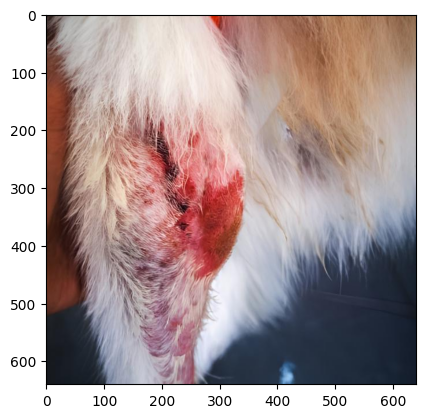

In [2]:
# Providing path to dataset
base_dir ='/kaggle/input/dogs-skin-diseases-image-dataset/train'
image_path='/kaggle/input/dogs-skin-diseases-image-dataset/train/Dermatitis/1000010518_x4_jpg.rf.2aa0ba9288c4a22c1b7efa0487c46e36.jpg'

# Reading the image
img=mpimg.imread(image_path)
print(img.shape)

#display image
plt.imshow(img)
plt.axis()
plt.show()

Found 2269 images belonging to 6 classes.
Found 753 images belonging to 6 classes.
Class indices: {'Dermatitis': 0, 'Fungal_infections': 1, 'Healthy': 2, 'Hypersensitivity': 3, 'demodicosis': 4, 'ringworm': 5}
Class sample counts: [410 282 369 173 441 594]


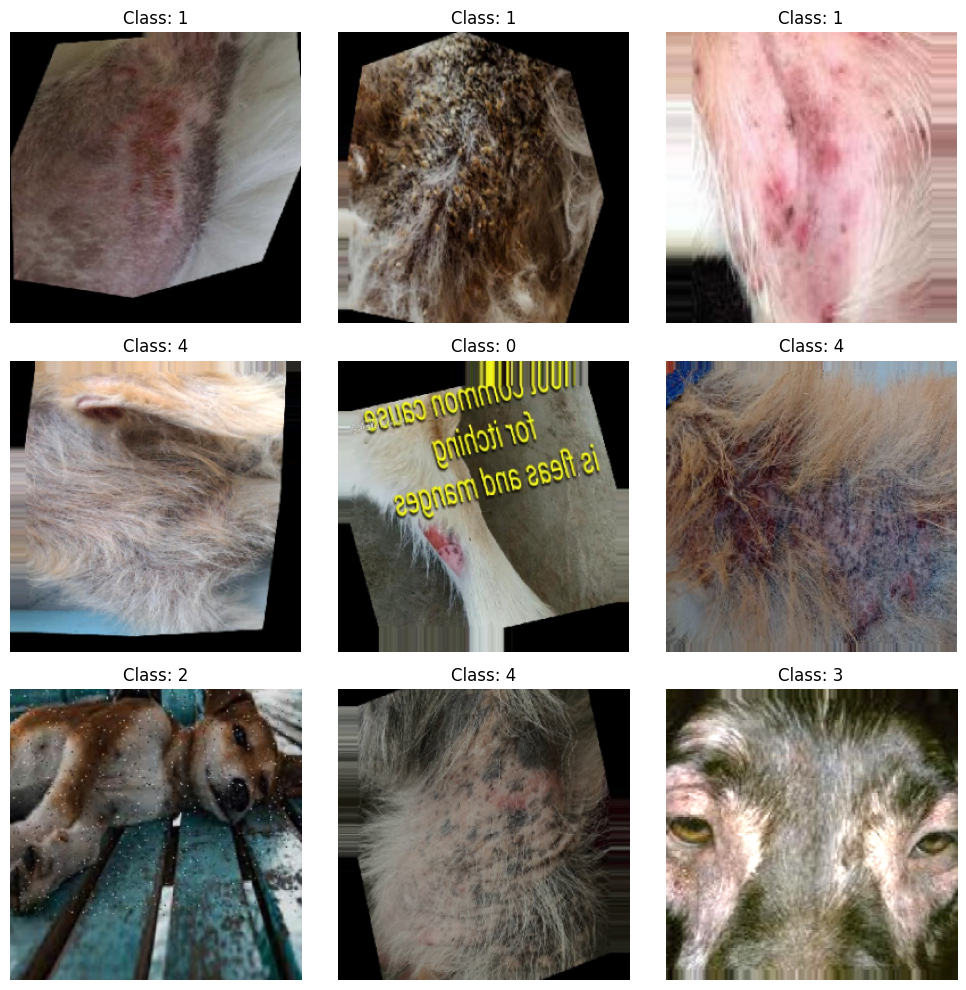

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input  # ✅ ResNetV2-specific

# Settings
img_size = 256
batch_size = 32

# Custom resize + pad + ResNetV2 preprocessing
def resize_pad_resnetv2(img):
    desired_size = 256
    old_size = img.shape[:2]  # (height, width)

    # Compute ratio and new size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize
    img = cv2.resize(img, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # Padding (reflect mode to avoid black edges)
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_REFLECT)

    # Convert to float32 for preprocess_input
    padded_img = padded_img.astype(np.float32)

    # Apply ResNetV2-specific normalization (-1 to +1 range)
    padded_img = preprocess_input(padded_img)

    return padded_img

# ✅ ImageDataGenerator setup
data_gen = ImageDataGenerator(
    preprocessing_function=resize_pad_resnetv2,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    validation_split=0.25
)

# ✅ Data generators
train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Class sample counts:", np.bincount(train_gen.classes))

# ✅ Preview a few preprocessed images
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((x_batch[i] + 1) / 2)  # convert [-1,1] back to [0,1] for display
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

# Convert array → dict (required by Keras)
class_weights = dict(enumerate(cw))

print(class_weights)

{0: 0.9223577235772358, 1: 1.341016548463357, 2: 1.0248419150858175, 3: 2.1859344894026975, 4: 0.8575207860922147, 5: 0.6366442199775533}


In [5]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Conv2D(8, (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(6, activation='softmax') 
])

model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen, validation_data=valid_gen, epochs=20,class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763559762.090826      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 921,430 (3.51 MB)

 Trainable params: 921,430 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763559768.654603      76 service.cc:148] XLA service 0x7fd54c1132c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763559768.655255      76 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763559769.101085      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/71 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.2500 - loss: 1.8573

I0000 00:00:1763559772.930499      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 77s 988ms/step - accuracy: 0.1704 - loss: 1.7810 - val_accuracy: 0.2815 - val_loss: 1.7083
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 753ms/step - accuracy: 0.3011 - loss: 1.6652 - val_accuracy: 0.2576 - val_loss: 1.7121
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 739ms/step - accuracy: 0.3365 - loss: 1.6087 - val_accuracy: 0.2244 - val_loss: 1.7551
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 729ms/step - accuracy: 0.4113 - loss: 1.4345 - val_accuracy: 0.3068 - val_loss: 1.6874
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 729ms/step - accuracy: 0.4044 - loss: 1.4665 - val_accuracy: 0.2988 - val_loss: 1.7861
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 735ms/step - accuracy: 0.4487 - loss: 1.3586 - val_accuracy: 0.3068 - val_loss: 1.7800
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 732ms/step - accuracy: 0.5346 - loss: 1.2142 - val_accuracy: 0.3320 - val_loss: 1.7982
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 732ms/step - accuracy: 0.5227 - loss: 1.2539 - val_accuracy: 0.338

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true and predicted labels
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

# Report
print(classification_report(Y_true,Y_pred,target_names=valid_gen.class_indices.keys()))


24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step
                   precision    recall  f1-score   support

       Dermatitis       0.31      0.30      0.31       136
Fungal_infections       0.20      0.26      0.23        93
          Healthy       0.37      0.57      0.45       123
 Hypersensitivity       0.11      0.12      0.12        57
      demodicosis       0.70      0.43      0.53       147
         ringworm       0.56      0.46      0.51       197

         accuracy                           0.39       753
        macro avg       0.38      0.36      0.36       753
     weighted avg       0.43      0.39      0.40       753



24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step


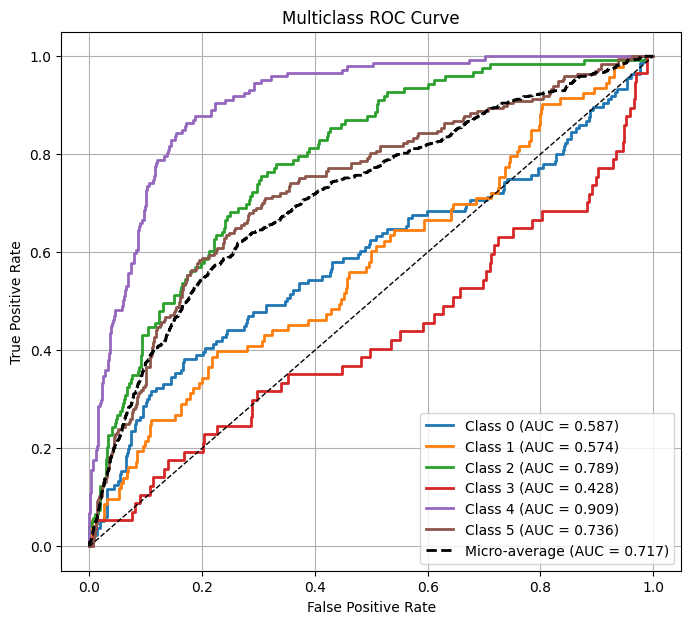

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# True labels
Y_true = valid_gen.classes

# Predicted probabilities
Y_prob = model.predict(valid_gen)

# Number of classes
n_classes = Y_prob.shape[1]

# Convert true labels to one-hot encoded format
Y_true_bin = label_binarize(Y_true, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), Y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8, 7))

# Plot per-class ROC
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='black', linestyle='--', linewidth=2)

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()